## Vector Autoregression (VAR)

In [16]:
# Import all required libraries
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.vector_ar.var_model import VAR
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller

In [17]:
# Import feature and target columns
df = pickle.load(open("../common/pima.p", "rb"))

### Setup data

In [18]:
# Convert the 'time' column to datetime format and set it as the index
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)

# Select the metrics you want to use as input to the VAR model
selected_metrics = ['cpu_usage','memory_usage','bandwidth_inbound','bandwidth_outbound','tps','tps_error','response_time']

# Difference the data to make it stationary
df_diff = df[selected_metrics].diff().dropna()

# Split the data into training set and test set
df_train, df_test = train_test_split(df_diff, test_size=0.2, shuffle=False)

### Check for Stationarity 

In [19]:
# Stationarity test
def adfuller_test(series, signif=0.05):
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue']
    return p_value

# Apply ADF test to each column
for name, column in df[selected_metrics].items():
    p_value = adfuller_test(column, signif=0.05)
    print(f'ADF Test on "{name}", p-value: {p_value}')

ADF Test on "cpu_usage", p-value: 0.0
ADF Test on "memory_usage", p-value: 0.0
ADF Test on "bandwidth_inbound", p-value: 0.0
ADF Test on "bandwidth_outbound", p-value: 0.0
ADF Test on "tps", p-value: 0.0
ADF Test on "tps_error", p-value: 0.0
ADF Test on "response_time", p-value: 0.0


### Train the model

In [20]:
# Fit the VAR model on the training set
model = VAR(df_train)

# Select optimal lag order using Akaike Information Criterion (AIC)
lag_order = model.select_order(maxlags=12).aic

# Fit the model
var_result = model.fit(lag_order)

# Use the fitted model to make predictions on the test set
predictions = var_result.forecast(df_train.values[-lag_order:], steps=len(df_test))

# Convert predictions to a DataFrame
predictions_df = pd.DataFrame(predictions, index=df_test.index, columns=df_test.columns)

c:\Users\dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 5S will be used.
  self._init_dates(dates, freq)


### Visualize the model

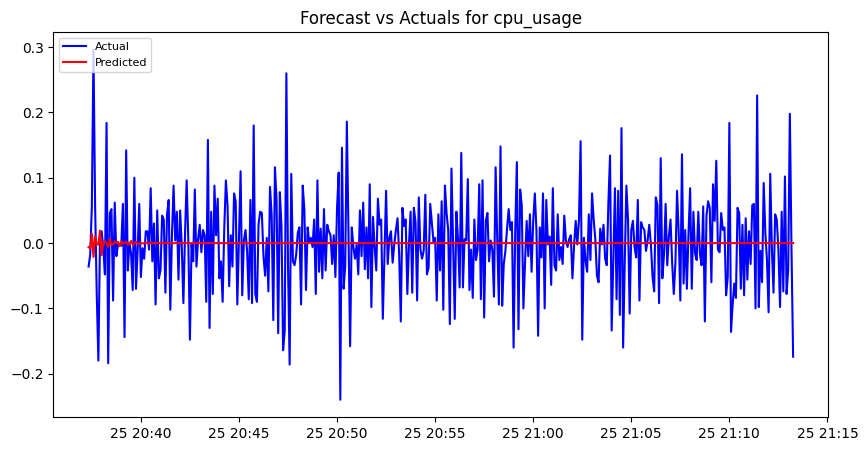

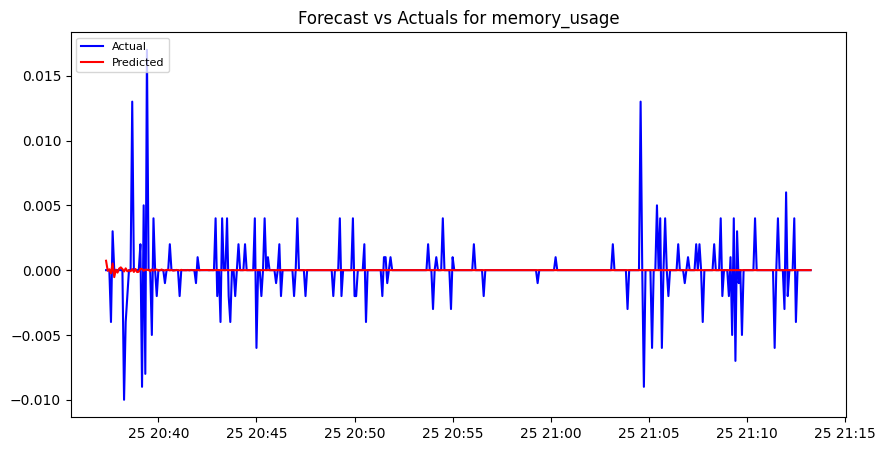

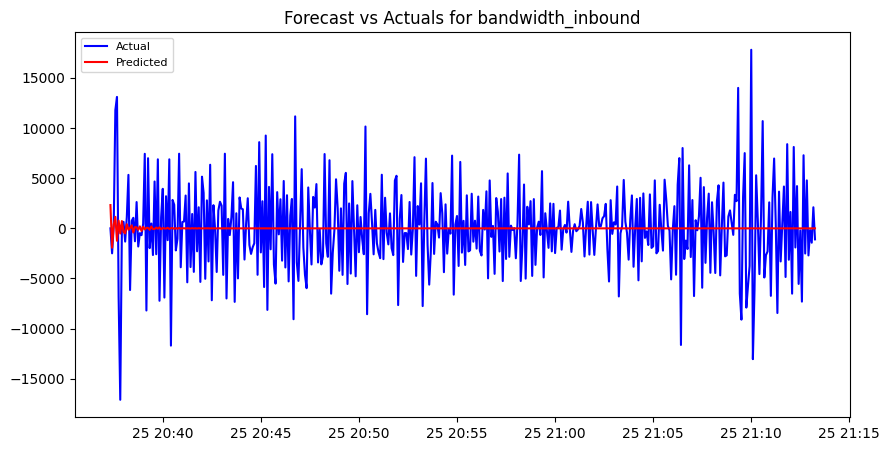

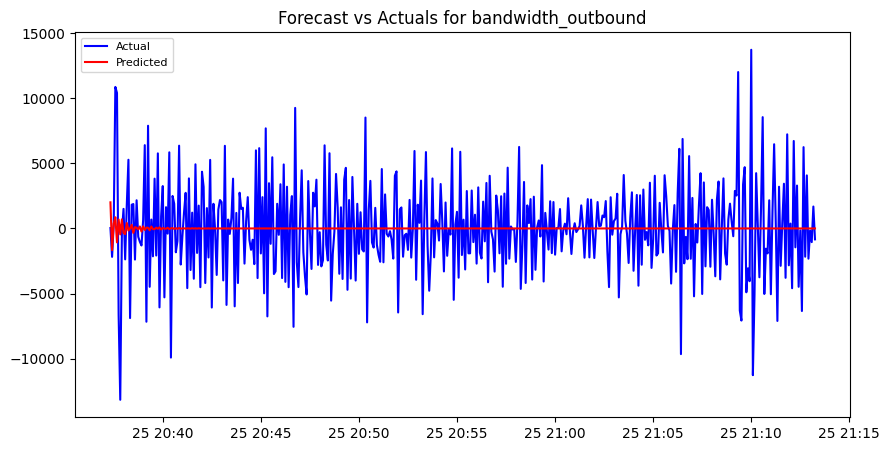

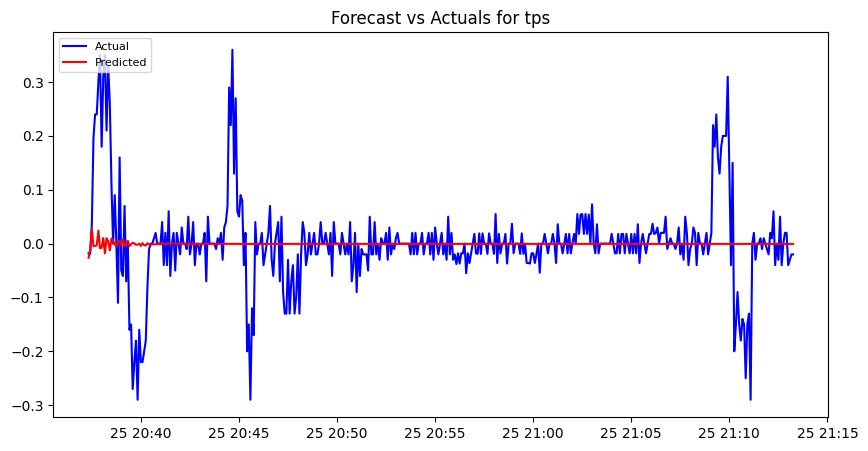

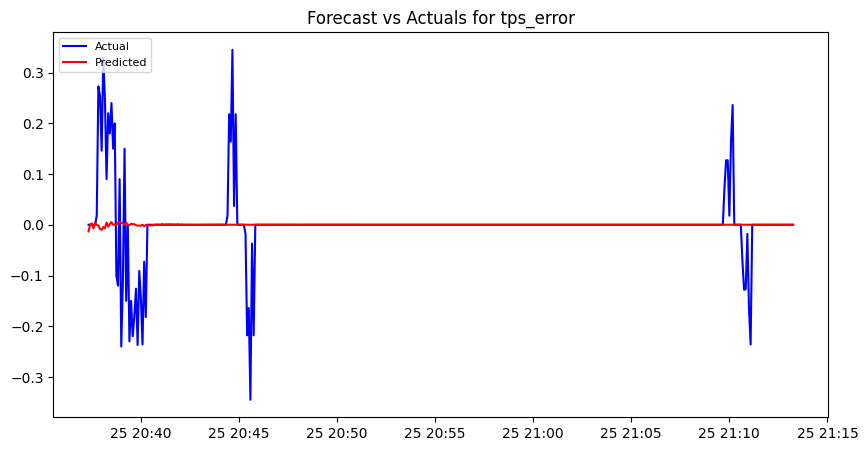

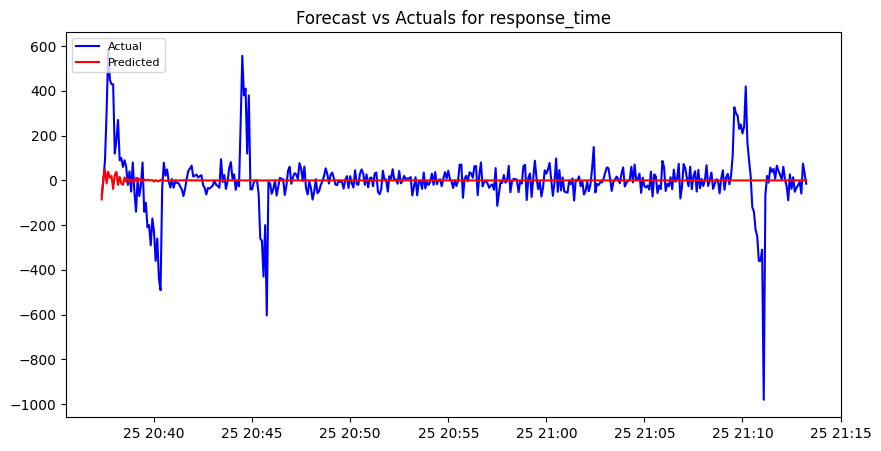

In [21]:
# Plot the actual vs predicted values
for i in range(len(selected_metrics)):
    plt.figure(figsize=(10,5))
    plt.plot(df_test.index, df_test[selected_metrics[i]], color='blue', label='Actual')
    plt.plot(predictions_df.index, predictions_df[selected_metrics[i]], color='red', label='Predicted')
    plt.title('Forecast vs Actuals for ' + selected_metrics[i])
    plt.legend(loc='upper left', fontsize=8)
    plt.show()

### Export the model

In [23]:
pickle.dump(model, open("../models/multi-step-multivariate/var_v2.p", "wb"))